## Aerosol Optical Depth (ABI-L2-AOD)

In [89]:
p2f = pl.Path('/mnt/telg/data/smoke_events/20200912_18_CO/goes_raw/ABI_L2_AODC_M6_G16/OR_ABI-L2-AODC-M6_G16_s20202571501154_e20202571503527_c20202571506226.nc')
sat_aod = ngs.open_class_file(p2f)

In [90]:
sat_aod.ds

<xarray.Dataset>
Dimensions:                                                 (land_sensor_bands: 3, latitude_bands: 18, num_area_types: 2, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_latitude_band_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, sea_sensor_bands: 4, x: 2500, y: 1500)
Coordinates:
    t                                                       datetime64[ns] ...
  * y                                                       (y) float32 0.128...
  * x                                                       (x) float32 -0.10...
    y_image                                                 float32 ...
    x_image                                                 float32 ...
    sunglint_angle                                          float32 ...
    retrieval_local_zenith_angle                            float32 ...
    quantitative_local_zenith_angle                         float32 ...
    retrieval_solar_zenith_angle                            float32 ...
    quantitative_solar_zenith_angle                         float32 ...
    aod_product_wavelength                                  float32 ...
  * latitude_bands                                          (latitude_bands) float32 ...
Dimensions without coordinates: land_sensor_bands, num_area_types, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_latitude_band_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds, sea_sensor_bands
Data variables:
    AOD                                                     (y, x) float32 ...
    DQF                                                     (y, x) float32 ...
    AE1                                                     (y, x) float32 ...
    AE2                                                     (y, x) float32 ...
    AE_DQF                                                  (y, x) float32 ...
    time_bounds                                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                                  int32 ...
    y_image_bounds                                          (number_of_image_bounds) float32 ...
    x_image_bounds                                          (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                          float32 ...
    nominal_satellite_subpoint_lon                          float32 ...
    nominal_satellite_height                                float32 ...
    geospatial_lat_lon_extent                               float32 ...
    sunglint_angle_bounds                                   (number_of_sunglint_angle_bounds) float32 ...
    retrieval_local_zenith_angle_bounds                     (number_of_LZA_bounds) float32 ...
    quantitative_local_zenith_angle_bounds                  (number_of_LZA_bounds) float32 ...
    retrieval_solar_zenith_angle_bounds                     (number_of_SZA_bounds) float32 ...
    quantitative_solar_zenith_angle_bounds                  (number_of_SZA_bounds) float32 ...
    land_sensor_band_wavelengths                            (land_sensor_bands) float32 ...
    sea_sensor_band_wavelengths                             (sea_sensor_bands) float32 ...
    land_sensor_band_ids                                    (land_sensor_bands) uint8 ...
    sea_sensor_band_ids                                     (sea_sensor_bands) uint8 ...
    latitude_band_bounds                                    (latitude_bands, number_of_latitude_band_bounds) float32 ...
    snow_free_land_and_ice_free_sea                         (num_area_types) |S14 ...
    goes_lat_lon_projection                                 int32 ...
    aod550_retrievals_attempted_land                        float64 ...
    aod550_retrievals_attempted_sea                         float64 ...
    aod550_good_LZA_retrievals_attempted                    float64 ...
    aod550_outlier_pixel_count                              float64 ...
    min_ao

/mnt/telg/prog/nesdis_gml_synergy/nesdis_gml_synergy/satlab.py:408: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  bmap.pcolormesh(lons, lats, self.ds[param], latlon=True, zorder = 0)


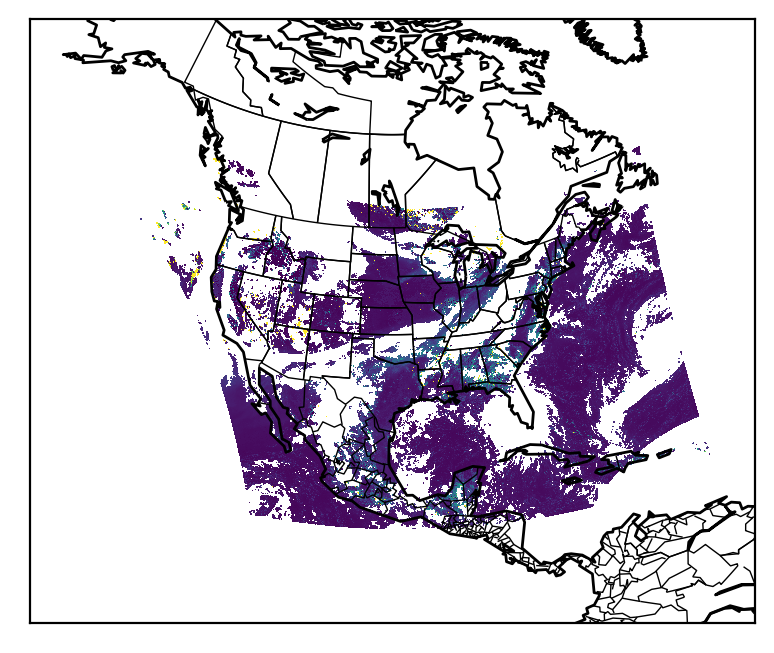

In [91]:
sat_aod.plot('AOD')

### Download and project (is this still how it is done?)

In [2]:
import pathlib as pl
import nesdis_aws
import nesdis_gml_synergy.satlab as ngs
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as surfrad
import os
os.getpid()

209397

In [3]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as surfrad

In [4]:
stations = surfrad.network.stations

In [5]:
def function(row, stations, variable):
    # read the file
    ngsinst = ngs.open_file(row.path2file_local)
    
    # project to stations
    projection = ngsinst.project_on_sites(stations)

    # merge closest gridpoint and area
    point = projection.projection2point.copy()#.sel(site = 'TBL')
    point['DQF'] = point.DQF.astype(int) # for some reason this was float64
    ds = projection.projection2area.merge(point.rename({variable: f'{variable}_on_pixel', 'DQF': 'DQF_on_pixel'}))
    
    # add a time stamp
    dt = pd.Series([pd.to_datetime(ngsinst.ds.attrs['time_coverage_start']), pd.to_datetime(ngsinst.ds.attrs['time_coverage_end'])]).mean().to_datetime64()
    ds = ds.expand_dims({'datetime': [dt]}, )

    # global attribute
    ds.attrs['info'] = ('This file contains a projection of satellite data onto SURFRAD sites.\n'
                         'It includes the closest pixel data as well as the average over circular\n'
                         'areas with various radii. Note, for the averaged data only data is\n'
                         'considered with a qulity flag given by the prooduct class in the\n'
                         'nesdis_gml_synergy package.')
    
    # save2file
    ds.to_netcdf(row.path2file_local_processed)
    return 

In [9]:
product = 'AOD'
query = nesdis_aws.nesdis_aws.AwsQuery(
                                        path2folder_local=f'/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_{product}/',
                                        satellite='17',
                                        product=f'ABI-L2-{product}',
                                        scan_sector='C',
                                        start='2017-05-26 18:00:00', #available since 2017-05-25
                                        end='2022-08-01 18:05:00',
                                        # start='2018-08-01 00:00:00',
                                        # end='2018-11-01 00:00:00',
                                        process = dict(#concatenate = 'daily',
                                                       function = lambda row: function(row, stations, product),
                                                       prefix = f'ABI_L2_{product}_projected2surfrad',
                                                       path2processed = f'/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_{product}_projected2surfrad/'),
                                        # keep_files=True
                                      )

# pl.Path(f'/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_{product}').mkdir()
# pl.Path(f'/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_{product}_projected2surfrad/').mkdir()

In [10]:
query.product_available_since

Timestamp('2018-08-28 00:00:00')

In [11]:
query.workplan

,path2file_aws,path2file_local,path2file_local_processed
2017-05-26 18:02:18,noaa-goes16/ABI-L2-AODC/2017/146/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2017-05-26 18:07:18,noaa-goes16/ABI-L2-AODC/2017/146/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2017-05-26 18:12:18,noaa-goes16/ABI-L2-AODC/2017/146/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2017-05-26 18:17:18,noaa-goes16/ABI-L2-AODC/2017/146/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2017-05-26 18:22:18,noaa-goes16/ABI-L2-AODC/2017/146/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
...,...,...,...
2022-03-08 18:31:17,noaa-goes16/ABI-L2-AODC/2022/067/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2022-03-08 18:36:17,noaa-goes16/ABI-L2-AODC/2022/067/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2022-03-08 18:41:17,noaa-goes16/ABI-L2-AODC/2022/067/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2022-03-08 18:46:17,noaa-goes16/ABI-L2-AODC/2022/067/18/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...


In [12]:
query.workplan = query.workplan.sample(frac=1) # shuffel workplan

In [ ]:
query.process()

In [10]:
outexists = query.workplan.apply(lambda row: row.path2file_local_processed.is_file(), axis = 1)

In [ ]:
row = query.workplan

In [21]:
query.workplan

,path2file_aws,path2file_local,path2file_local_processed
2018-08-01 00:02:21,noaa-goes16/ABI-L2-AODC/2018/213/00/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-08-01 00:07:21,noaa-goes16/ABI-L2-AODC/2018/213/00/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-08-01 00:12:21,noaa-goes16/ABI-L2-AODC/2018/213/00/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-08-01 00:17:21,noaa-goes16/ABI-L2-AODC/2018/213/00/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-08-01 00:22:21,noaa-goes16/ABI-L2-AODC/2018/213/00/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
...,...,...,...
2018-10-31 23:37:19,noaa-goes16/ABI-L2-AODC/2018/304/23/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-10-31 23:42:19,noaa-goes16/ABI-L2-AODC/2018/304/23/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-10-31 23:47:19,noaa-goes16/ABI-L2-AODC/2018/304/23/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...
2018-10-31 23:52:19,noaa-goes16/ABI-L2-AODC/2018/304/23/OR_ABI-L2-...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...,/nfs/stu3data2/Satellite_data/goes/16/ABI_L2_A...


In [7]:
# function(query.workplan.iloc[0], stations, 'COD')

/mnt/telg/programs/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/telg/programs/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/telg/programs/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/telg/programs/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [10]:
dst = xr.open_dataset(query.workplan.iloc[0].path2file_local_processed)

In [11]:
dst

<xarray.Dataset>
Dimensions:                     (datetime: 1, radius: 5, stats: 3, site: 7)
Coordinates:
  * datetime                    (datetime) datetime64[ns] 2018-08-01T18:03:41...
  * radius                      (radius) int64 5 10 25 50 100
  * stats                       (stats) object 'median' 'mean' 'std'
  * site                        (site) object 'BND' 'SXF' 'TBL' ... 'GWN' 'PSU'
Data variables:
    AOD                         (datetime, radius, stats, site) float32 ...
    DQF                         (datetime, radius, stats, site) float32 ...
    num_of_valid_points         (datetime, radius, site) int64 ...
    AOD_on_pixel                (datetime, site) float32 ...
    DQF_on_pixel                (datetime, site) int64 ...
    argmin_x                    (datetime, site) float32 ...
    argmin_y                    (datetime, site) float32 ...
    lon_gritpoint               (datetime, site) float32 ...
    lat_gridpoint               (datetime, site) float32 ...
    lon_station                 (datetime, site) float32 ...
    lat_station                 (datetime, site) float32 ...
    distance_station_gridpoint  (datetime, site) float32 ...
Attributes:
    info:     This file contains a projection of satellite data onto SURFRAD ...

# resulting file

In [34]:
# fn = pl.Path('/export/htelg/tmp/ABI_L2_AOD_projected2surfrad_20180828_190202.nc')
fn = pl.Path('/nfs/stu3data2/Satellite_data/goes/17/ABI_L2_AOD_projected2surfrad/')

In [41]:
list(fn.glob('*'))[0]

PosixPath('/nfs/stu3data2/Satellite_data/goes/17/ABI_L2_AOD_projected2surfrad/ABI_L2_AOD_projected2surfrad_20220708_025617.nc')

In [42]:
list(fn.glob('*'))[-1]

PosixPath('/nfs/stu3data2/Satellite_data/goes/17/ABI_L2_AOD_projected2surfrad/ABI_L2_AOD_projected2surfrad_20220418_123117.nc')

In [43]:
fl = list(fn.glob('*'))

In [44]:
fl.sort()

In [45]:
ds = xr.open_dataset(fl[-1])

In [46]:
ds

<xarray.Dataset>
Dimensions:                     (datetime: 1, radius: 5, stats: 3,
                                 data_quality: 5, site: 7)
Coordinates:
  * datetime                    (datetime) datetime64[ns] 2022-08-29T05:57:36...
  * radius                      (radius) int64 5 10 25 50 100
  * stats                       (stats) object 'median' 'mean' 'std'
  * site                        (site) object 'BND' 'SXF' 'TBL' ... 'GWN' 'PSU'
  * data_quality                (data_quality) object 'high' ... 'low'
Data variables: (12/18)
    AOD                         (datetime, data_quality, radius, stats, site) float32 ...
    AE1                         (datetime, data_quality, radius, stats, site) float32 ...
    AE2                         (datetime, data_quality, radius, stats, site) float32 ...
    num_of_valid_points         (datetime, data_quality, radius, site) int64 ...
    AOD_on_pixel                (datetime, site) float32 ...
    AOD_on_pixel_DQF_assessed   (datetime, site) int8 ...
    ...                          ...
    argmin_y                    (datetime, site) float32 ...
    lon_gritpoint               (datetime, site) float32 ...
    lat_gridpoint               (datetime, site) float32 ...
    lon_station                 (datetime, site) float32 ...
    lat_station                 (datetime, site) float32 ...
    distance_station_gridpoint  (datetime, site) float32 ...
Attributes:
    info:     This file contains a projection of satellite data onto SURFRAD ...

In [33]:
list(ds.variables)

['datetime',
 'radius',
 'stats',
 'AOD',
 'site',
 'num_of_valid_points',
 'data_quality',
 'AOD_on_pixel',
 'AOD_on_pixel_DQF_assessed',
 'DQF_on_pixel',
 'argmin_x',
 'argmin_y',
 'lon_gritpoint',
 'lat_gridpoint',
 'lon_station',
 'lat_station',
 'distance_station_gridpoint']

In [21]:
for var in ds.variables

KeysView(Frozen({'datetime': <xarray.IndexVariable 'datetime' (datetime: 1)>
array(['2018-08-28T19:03:21.449999872'], dtype='datetime64[ns]'), 'radius': <xarray.IndexVariable 'radius' (radius: 5)>
array([  5,  10,  25,  50, 100])
Attributes:
    long_name:  Radius of area around point over which data statistics are ca..., 'stats': <xarray.IndexVariable 'stats' (stats: 3)>
array(['median', 'mean', 'std'], dtype=object)
Attributes:
    long_name:  Statistics of values in circlular area around site, 'AOD': <xarray.Variable (datetime: 1, data_quality: 5, radius: 5, stats: 3, site: 7)>
[525 values with dtype=float32]
Attributes:
    long_name:            ABI L2+ Aerosol Optical Depth at 550 nm
    standard_name:        atmosphere_extinction_optical_thickness_due_to_ambi...
    valid_range:          [ 0 -6]
    units:                1
    resolution:           y: 0.000056 rad x: 0.000056 rad
    grid_mapping:         goes_imager_projection
    cell_methods:         sunglint_angle: point (no 